# Make labels for songs

In [1]:
from starling_rhythm.utils.paths import PROCESSED_DIR
import pandas as pd

In [2]:
bID = 's_b1555_22'

In [3]:
bID_DIR = PROCESSED_DIR / bID
wav_list = list(bID_DIR.glob('*.wav'))

In [4]:
wav_df = pd.DataFrame({'file':wav_list})

In [5]:
wav_df.head()

,file
0,/mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...
1,/mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...
2,/mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...
3,/mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...
4,/mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...


## Segment

In [6]:
import numpy as np
from scipy.io.wavfile import read
from avgn.signalprocessing.filtering import butter_bandpass_filter
from starling_rhythm.utils.audio import int16_to_float32
from vocalseg.dynamic_thresholding import dynamic_threshold_segmentation, plot_segmented_spec, plot_segmentations

/home/AD/j8xing/avgn_paper/avgn/utils/general.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [7]:
### segmentation parameters
min_level_db = -100 ## default dB minimum of spectrogram (threshold anything below)
min_level_db_floor = -60 ## highest number min_level_db is allowed to reach dynamically
db_delta = 5 ## delta in setting min_level_db
n_fft = 1024 ## FFT window size
hop_length_ms = 1 ## number audio of frames in ms between STFT columns
win_length_ms = 5 ## size of fft window (ms)
ref_level_db = 20 ## reference level dB of audio
pre = 0.97 ## coefficient for preemphasis filter
spectrogram_range = None ## spectral range to care about for spectrogram
verbose = False ## display output
mask_thresh_std = 0.8 ## standard deviations above median to threshold out noise (higher = threshold more noise)
neighborhood_time_ms = 5 ## size in time of neighborhood-continuity filter
neighborhood_freq_hz = 500 ## size in Hz of neighborhood-continuity filter
neighborhood_thresh = 0.5 ## threshold number of neighborhood time-frequency bins above 0 to consider a bin not noise
min_syllable_length_s = 0.075 ## shortest expected length of syllable
min_silence_for_spec = 0.025 ## shortest expected length of silence in a song (used to set dynamic threshold)
silence_threshold = 0.0 ## threshold for spectrogram to consider noise as silence
max_vocal_for_spec = 2.0 ## longest expected vocalization in seconds
temporal_neighbor_merge_distance_ms = 0 ##longest distance at which two elements should be considered one
overlapping_element_merge_thresh = np.inf ##proportion of temporal overlap to consider two elements one
min_element_size_ms_hz = [0,0] ## smallest expected element size (in ms and Hz). Everything smaller is removed
butter_min = 500
butter_max = 15000
figsize = (20,5)

In [8]:
def segment_spec_custom(address, plot = True):
    
    ## load in wav
    rate, data = read(address)
    
    ## coerce data to float32
    data = int16_to_float32(data)
    
    ## pass data through a filter
    data = butter_bandpass_filter(data, butter_min, butter_max, rate)
    
    ## segment
    results = dynamic_threshold_segmentation(
        data,
        rate,
        n_fft=n_fft,
        hop_length_ms=hop_length_ms,
        win_length_ms=win_length_ms,
        min_level_db_floor=min_level_db_floor,
        db_delta=db_delta,
        ref_level_db=ref_level_db,
        pre=pre,
        max_vocal_for_spec=max_vocal_for_spec,
        min_level_db=min_level_db,
        silence_threshold=silence_threshold,
        verbose=False,
        min_syllable_length_s=min_syllable_length_s,
    )
    
    if plot:
        plot_segmentations(
            results["spec"],
            results["vocal_envelope"],
            results["onsets"],
            results["offsets"],
            hop_length_ms,
            rate,
        )
        plt.show()
        
    return {
        'onsets': results['onsets'], 
        'offsets': results['offsets']
    }

In [9]:
from joblib import Parallel, delayed
from tqdm.autonotebook import tqdm

n_jobs = 36
verbose = 0

In [10]:
with Parallel(n_jobs = n_jobs, verbose = verbose) as parallel:
    segs = parallel(
        delayed(segment_spec_custom)(
            data, 
            plot = False
        )
        for data in tqdm(wav_df['file'], desc = 'Segmenting all songs')
    )

Segmenting all songs: 100%|██████████| 1041/1041 [11:48<00:00,  1.47it/s]


In [11]:
wav_df['segmentations'] = segs

In [12]:
## make columns
file = []

onsets_ms = []
offsets_ms = []

## for each bout
for index, bout_info in wav_df.iterrows():
    
    ## get each syllable
    for onset, offset in zip(bout_info.segmentations['onsets'], bout_info.segmentations['offsets']):
        
        ## populate columns
        file.append(bout_info.file)
        onsets_ms.append(onset)
        offsets_ms.append(offset)
        
        
syllable_df = pd.DataFrame(
    {
        'file': file,
        'onsets_ms': onsets_ms,
        'offsets_ms': offsets_ms
    }
)

In [13]:
syllable_df.head()['file'][0]

PosixPath('/mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_b1555_22/s_b1555_22_2022-09-21_19-00-01-02_1204225_1234665.wav')

## Get syllable audio

In [14]:
from starling_rhythm.utils.audio import int16_to_float32
from tqdm.autonotebook import tqdm
import numpy as np

In [15]:
def get_waveform(file, onsets_ms, offsets_ms):
    
    ## for each syllable, load in the waveform corresponding to the bout index
    rate, waveform = read(file)
    
    ## slice out
    strt = int(onsets_ms * rate)
    end = int(offsets_ms * rate)
    return waveform[strt:end]

In [16]:
with Parallel(n_jobs = n_jobs, verbose = verbose) as parallel:
    syl_audio = parallel(
        delayed(get_waveform)(
            file,
            onsets_ms,
            offsets_ms
        )
        for file, onsets_ms, offsets_ms in tqdm(zip(syllable_df['file'], syllable_df['onsets_ms'], syllable_df['offsets_ms']), desc = 'Segmenting all songs')
    )

Segmenting all songs: 60381it [00:16, 3654.31it/s]


In [17]:
syllable_df['audio'] = syl_audio
syllable_df['audio'] = [i/np.max(i) for i in syllable_df['audio'].values] ## normalize
syllable_df['rate'] = np.full(len(syllable_df), 48000)

## Create Spectrograms

In [18]:
from avgn.utils.hparams import HParams
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.filtering import prepare_mel_matrix
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [19]:
syllables_wav = syllable_df.audio.values
syllables_rate = syllable_df.rate.values

In [20]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=500,
    mel_upper_edge_hertz=20000,
    butter_lowcut = 500,
    butter_highcut = 20000,
    ref_level_db = 20,
    min_level_db = -45,
    mask_spec = True,
    win_length_ms = 10,
    hop_length_ms = 2,
    nex=-1,
    n_jobs=-1,
    verbosity = 0,
) ## from Tim

In [21]:
from joblib import Parallel, delayed
n_jobs = 36
verbosity = 0

In [22]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=hparams,
            mel_matrix=prepare_mel_matrix(hparams, rate),
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

getting syllable spectrograms:   0%|          | 0/60381 [00:00<?, ?it/s]2022-11-10 15:41:19.753343: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.2/lib64
2022-11-10 15:41:19.753403: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-10 15:41:19.788873: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-10 15:41:20.639405: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.2/lib64
2022-11-10 15:41:20.63

## Log rescale

In [23]:
log_scaling_factor = 4

In [24]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

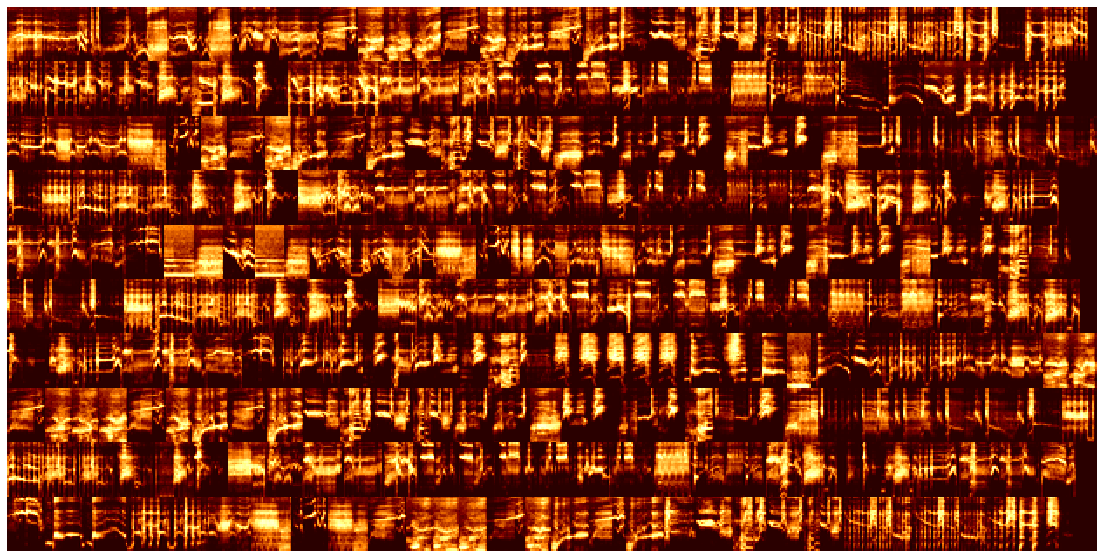

In [25]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

## Pad spectrograms

In [26]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)

In [27]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

In [28]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))
syllables_spec = [(norm(i)*255).astype('uint8') for i in tqdm(syllables_spec)]
# convert to uint8 to save space
syllable_df['spectrogram'] = syllables_spec

100%|██████████| 60381/60381 [00:04<00:00, 13231.22it/s]


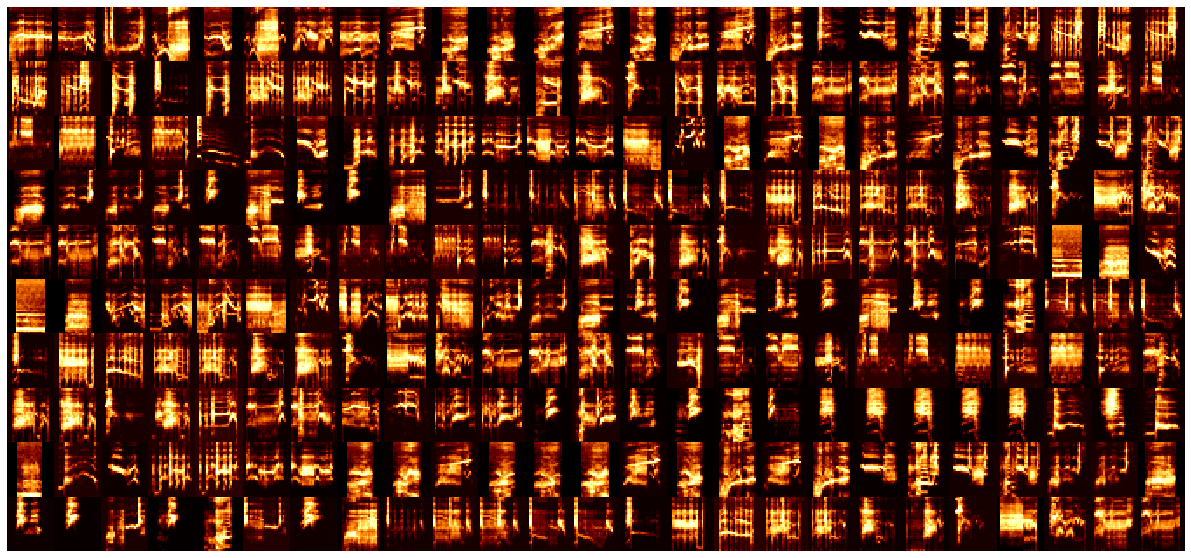

In [29]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

## Pickle dataframe

In [30]:
from starling_rhythm.utils.paths import PROCESSED_DIR, ensure_dir

In [31]:
SAVE_PATH = PROCESSED_DIR / bID / 'syllable_df.pickle'
ensure_dir(SAVE_PATH)

In [32]:
syllable_df.to_pickle(SAVE_PATH)